In [4]:
import json
import os
import re
import pandas as pd
import matplotlib as mpl
import numpy as np
import logging
import glob
import shutil
from distutils.dir_util import copy_tree
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from scipy.signal import savgol_filter
import toml

import pickle
import os
import logging
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.spatial.transform import Rotation as R
from scipy.spatial.transform import Slerp
import seaborn as sns

pd.options.mode.chained_assignment = None

from ipynb.fs.full.V07_Utils  import *

In [6]:
import os
import numpy as np
import glob
import pandas as pd  
import random
import math as mp
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from pickle import load

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow.keras.backend as K


from tensorflow.keras.models import Sequential
from tensorflow.keras.models import model_from_yaml
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.layers import Conv1D,MaxPooling1D
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import GlobalMaxPooling1D

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from pyquaternion import Quaternion

from numpy import array
from numpy import hstack

from math import floor
import toml


from ipynb.fs.full.V07_Utils  import *

In [9]:
######################################################################
# Load Configuration
######################################################################

config_path = 'C:/Users/Thomas Weikert/Documents/Thesis/Project_V07_24092021/Code/V07_config.toml'
cfg = toml.load(config_path)


######################################################################
# GRU quat directories
######################################################################
# Result path  
Path_results_dataset01_GRU_quat = cfg['Path_results_dataset01'] + "GRU_quat/"
# Figure path 
Path_figures_dataset01_GRU_quat = cfg['Path_figures_dataset01'] + "GRU_quat/"

######################################################################
# Baseline directories
######################################################################
# Result path  
Path_results_dataset01_Baseline_quat = cfg['Path_results_dataset01'] + "Baseline_quat/" + "Traces"
# Figure path 
Path_figures_dataset01_Baseline_quat = cfg['Path_figures_dataset01'] + "Baseline_quat/"

######################################################################
# Data directories
######################################################################
# Trace path  
Path_dataset01 = cfg['Path_dataset01'] 
# Figure path 
Path_figures_dataset01_Traces = cfg['Path_figures_dataset01'] + "Traces/"

In [10]:
def compute_pos_metrics(true_pos, preds_pos):
        # Compute Eucliden and angular distances
        euc_dists = np.linalg.norm(true_pos - preds_pos, axis=1)
        # Mean Absolute Error (MAE)
        mae_euc = sum(euc_dists) / euc_dists.shape[0]
        # Root Mean Squared Error (RMSE)
        rmse_euc = np.sqrt((euc_dists ** 2).mean())
        return euc_dists, mae_euc, rmse_euc


def compute_quat_metrics(true_rot, preds_rot,true_rot_quat, preds_rot_quat):
        # Compute Eucliden and angular distances
        ang_dists = np.array([Quaternion.distance(q1, q2) for q1, q2 in zip(true_rot_quat, preds_rot_quat)]) #(w, x, y, z)
        euc_dists = np.linalg.norm(true_rot - preds_rot, axis=1)
        # Mean Absolute Error (MAE)
        #mae_ang = np.rad2deg(np.sum(ang_dists) / ang_dists.shape[0])
        #mae_euc = np.rad2deg(np.sum(euc_dists) / euc_dists.shape[0])
        
        mae_ang = (np.sum(ang_dists) / ang_dists.shape[0])
        mae_euc = (np.sum(euc_dists) / euc_dists.shape[0])
        
        # Root Mean Squared Error (RMSE)
        rmse_ang = np.rad2deg(np.sqrt((ang_dists ** 2).mean()))
        rmse_euc = np.rad2deg(np.sqrt((euc_dists ** 2).mean()))
        return euc_dists, ang_dists, mae_ang, mae_euc, rmse_ang, rmse_euc

def eval_quat(true_rot, preds_rot):
        true_rot_quat = np.array([Quaternion(q) for q in true_rot]) #(w, x, y, z)
        preds_rot_quat = np.array([Quaternion(q) for q in preds_rot]) #(w, x, y, z)    
        return compute_quat_metrics(true_rot, preds_rot,true_rot_quat, preds_rot_quat)
    
def check_discontinuity(dataset):
        dataset = np.array([Quaternion(q) for q in dataset]) #(w, x, y, z)
        
        continious_dataset = []
        for q1,q2 in zip(dataset[:-1], dataset[1:]):
            if (Quaternion.distance(q1,q2) < Quaternion.distance(q1,-q2)):
                continious_dataset.append([q2[0],q2[1],q2[2],q2[3]])
            else:
                q2 = q2.inverse
                continious_dataset.append([q2[0],-q2[1],-q2[2],-q2[3]])
        
        
        #dataset_continious = np.array([-q2 for q1,q2 in zip(dataset[:-1],dataset[1:]) if (Quaternion.distance(q1,q2) > Quaternion.distance(q1,-q2)) ])
        
        
        #dataset_continious = next((-q2 for q1,q2 in zip(dataset[:-1],dataset[1:]) if  (Quaternion.distance(q1,q2) > Quaternion.distance(q1,-q2))), None)

        
        
        return np.array(continious_dataset)
    
def compute_euler_metrics(Dataset_path_result_euler, keyword):
        df = pd.read_csv(Dataset_path_result_euler)
        df_pred = np.deg2rad(df[keyword + '_pred']%360)          
        df_true = np.deg2rad(df[keyword + '_true']%360)
        ang_dists = []
        for i in range(len(df_true)):
                ang_dists1 = np.abs(df_true[i] - df_pred[i])
                ang_dists2 = np.abs(2*np.pi + df_true[i] - df_pred[i])
                ang_dists3 = np.abs(-2*np.pi + df_true[i] - df_pred[i])
                ang_dists_single = min(ang_dists1,ang_dists2,ang_dists3)
                ang_dists_single = np.rad2deg(ang_dists_single)
                ang_dists.append(ang_dists_single)
        ang_dists_arr = np.array(ang_dists)
        # Mean Absolute Error (MAE)
        mae_ang = (sum(ang_dists_arr) / ang_dists_arr.shape[0])
        return ang_dists_arr, mae_ang
    
    
def compute_euler_metrics_radiant(Dataset_path_result_euler, keyword):
        df = pd.read_csv(Dataset_path_result_euler)
        df_pred = (df[keyword + '_pred'])          
        df_true = (df[keyword + '_true'])
        ang_dists = []
        for i in range(len(df_true)):
                sin = np.abs(df_true[i] - df_pred[i])
                cos = df_true[i] - df_pred[i]
                ang_dists_single = np.arctan2(sin,cos)
                ang_dists_single = np.rad2deg(ang_dists_single)
                ang_dists.append(ang_dists_single)
        ang_dists_arr = np.array(ang_dists)
        # Mean Absolute Error (MAE)
        mae_ang = (sum(ang_dists_arr) / ang_dists_arr.shape[0])
        return ang_dists_arr, mae_ang

In [11]:
############################
# Discountinuity quaternion 
############################

def discontinuity_quaternion(Path_dataset):
    
    for csv in get_csv_files(Path_dataset, "2_full"):
            print(csv)
            trace_id = os.path.splitext(os.path.basename(csv))[0]
            csv_df = load_df(csv)
            q = csv_df[:-1]
            
            in_seq1 = q[['qw']].to_numpy()
            in_seq2 = q[['qx']].to_numpy()
            in_seq3 = q[['qy']].to_numpy()
            in_seq4 = q[['qz']].to_numpy()

        


            #print("pred len is" + str(len(csv_df))
            dataset = hstack((in_seq1, in_seq2, in_seq3, in_seq4))
            data = check_discontinuity(dataset)
            
            data_df = pd.DataFrame(np.row_stack(data), columns= cfg['quat_coords'])

            data_df.to_csv(os.path.join(Path_results_dataset01_Baseline_quat, '_result_continious.csv'), index=False)

            
    return data

In [12]:
############################
# Evaluation quaternion 
############################

def eval_quaternion(Path_dataset):
    
    for csv in get_csv_files(Path_dataset, "1_special_train"):
            print(csv)
            trace_id = os.path.splitext(os.path.basename(csv))[0]
            csv_df = load_df(csv)
            q1 = csv_df[:-2]
            q2 = csv_df[1:-1]
            
            in_seq1 = q1[['qw']].to_numpy()
            in_seq2 = q1[['qx']].to_numpy()
            in_seq3 = q1[['qy']].to_numpy()
            in_seq4 = q1[['qz']].to_numpy()

            in_seq5 = q2[['qw']].to_numpy()
            in_seq6 = q2[['qx']].to_numpy()
            in_seq7 = q2[['qy']].to_numpy()
            in_seq8 = q2[['qz']].to_numpy()


            #print("pred len is" + str(len(csv_df))
            dataset_pred = hstack((in_seq1, in_seq2, in_seq3, in_seq4))
            dataset_true = hstack((in_seq5, in_seq6, in_seq7, in_seq8))
            dataset_pred = array(dataset_pred)
            dataset_true = array(dataset_true)



            euc_dists, ang_dists, mae_ang, mae_euc, rmse_ang, rmse_euc = eval_quat(dataset_pred, dataset_true)
            print('Number of dists: ' + str(ang_dists.shape[0]))
            #print('Number of euclidean dists: ' + str(euc_dists.shape[0]))
            print('MAE_ang rotation is : ' + str(mae_ang))
            #print('RMSE_ang rotation is : ' + str(rmse_ang))
            print('MAE_euc rotation is : ' + str(mae_euc))
            #print('RMSE_euc rotation is : ' + str(rmse_euc))
            print("----")
            
    return ang_dists



In [13]:
def plot_quat_traces_joint(dataset_path, figures_path): 
     

    list_datasets = get_csv_files(dataset_path, "*2_full*")
    
    for single_dataset in list_datasets:

        df = pd.read_csv(single_dataset)
        #df = df[2100:2200]
        ts = np.arange(0, df.shape[0])
        
        trace_id = os.path.splitext(os.path.basename(single_dataset))[0]

        plt.figure(figsize=(18,8))
        

        
        ##################################################################
        # Plot quaternions in individual charts
        ##################################################################
        
        # Plot yaw true and yaw prediction in combined chart
        plt.plot(ts, df.loc[:, 'qw'], label='qw_true')
        plt.ylim(-1, 1)
        plt.legend(loc='upper left')
        dest = os.path.join(figures_path, "{}_joint_qw.pdf".format(trace_id))
        plt.savefig(dest)
        plt.clf()
        
        # Plot pitch true and yaw prediction in combined chart
        plt.plot(ts, df.loc[:, 'qx'], label='qx_true')
        plt.ylim(-1, 1)
        plt.legend(loc='upper left')
        dest = os.path.join(figures_path, "{}_joint_qx.pdf".format(trace_id))
        plt.savefig(dest)
        plt.clf()
        
        # Plot roll true and yaw prediction in combined chart
        plt.plot(ts, df.loc[:, 'qy'], label='qy_true')
        plt.ylim(-1, 1)
        plt.legend(loc='upper left')
        dest = os.path.join(figures_path, "{}_joint_qy.pdf".format(trace_id))
        plt.savefig(dest)
        plt.clf()
        
        # Plot roll true and yaw prediction in combined chart
        plt.plot(ts, df.loc[:, 'qz'], label='qz_true')
        plt.ylim(-1, 1)
        plt.legend(loc='upper left')
        dest = os.path.join(figures_path, "{}_joint_qz.pdf".format(trace_id))
        plt.savefig(dest)
        plt.clf()
        
        
        
        ##################################################################
        # Plot yaw, pitch and roll orientation in one chart
        ##################################################################
        
        #plt.plot(ts, df.loc[:, 'yaw_true'], label='yaw-interpolated')
        #plt.plot(ts, df.loc[:, 'pitch_true'], label='pitch-interpolated', linestyle='--')
        #plt.plot(ts, df.loc[:, 'roll_true'] , label='roll-interpolated', linestyle='-.')
        #plt.legend(loc='upper left')
        
        #plt.plot(ts, df.loc[:, 'yaw_pred']  , label='yaw-preds')
        #plt.plot(ts, df.loc[:, 'pitch_pred'], label='pitch-preds', linestyle='--')
        #plt.plot(ts,np.abs(df.loc[:, 'roll_pred'] - df.loc[:, 'roll_true']), label='roll_preds-roll_true', linestyle='-.')
        #plt.plot(ts,df.loc[:, 'roll_pred'], label='roll_preds', linestyle='-.')
        #plt.legend(loc='upper left')
        
        #trace_id = os.path.splitext(os.path.basename(single_dataset))[0]
        #
        
        #plt.savefig(dest)
        #plt.clf()
        
        
        #print("Plotted all orientation for trace {} and saving to file {}".format(single_dataset, dest))
    print("Done with traces")
        

In [14]:
def quat_error_calculation(Dataset_path_result_euler, keyword):
        df = pd.read_csv(Dataset_path_result_euler)
        df_pred = np.deg2rad(df[keyword + '_pred']%360)          
        df_true = np.deg2rad(df[keyword + '_true']%360)
        
        ang_dists = []
        for i in range(len(df_true)):
                ang_dists1 = np.abs(df_true[i] - df_pred[i])
                ang_dists2 = np.abs(2*np.pi + df_true[i] - df_pred[i])
                ang_dists3 = np.abs(-2*np.pi + df_true[i] - df_pred[i])
                
                ang_dists_single = min(ang_dists1,ang_dists2,ang_dists3)
                ang_dists_single = np.rad2deg(ang_dists_single)
                ang_dists.append(ang_dists_single)
        
        np.array(ang_dists)
        
        # Mean Absolute Error (MAE)
        mae_ang = sum(ang_dists) / len(ang_dists)
        
        return ang_dists, mae_ang

In [15]:
def plot_error(dataset_path, figures_path): 
     

    list_datasets = get_csv_files(dataset_path, "train")
    
    for single_dataset in list_datasets:
        df = pd.read_csv(single_dataset)
        ts = np.arange(0, df.shape[0])
              
        ang_dists_pitch, mae_ang_pitch = quat_error_calculation(single_dataset, "pitch")
        ang_dists_roll, mae_ang_roll = quat_error_calculation(single_dataset, "roll")
        ang_dists_yaw, mae_ang_yaw = quat_error_calculation(single_dataset, "yaw")
        
        df_ang_dists_pitch = pd.DataFrame(ang_dists_pitch, columns = ['ang_dists_pitch'])
        ang_dists_roll = pd.DataFrame(ang_dists_roll, columns = ['ang_dists_roll'])
        ang_dists_yaw = pd.DataFrame(ang_dists_yaw, columns = ['ang_dists_yaw'])
        
        plt.figure(figsize=(18,8))
        trace_id = os.path.splitext(os.path.basename(single_dataset))[0]
        
        #print(single_dataset)
                
        # Plot yaw error 
        plt.plot(ts, ang_dists_yaw.loc[:] , label='yaw_preds-yaw_true', linestyle='-.')
        plt.legend(loc='upper left')
        dest = os.path.join(figures_path, "{}_error_yaw.pdf".format(trace_id))
        plt.savefig(dest)
        plt.clf()
        
        # Plot pitch error
        plt.plot(ts,df_ang_dists_pitch.loc[:], label='pitch_preds-pitch_true', linestyle='-.')
        plt.legend(loc='upper left')
        dest = os.path.join(figures_path, "{}_error_pitch.pdf".format(trace_id))
        plt.savefig(dest)
        plt.clf()
        
        # Plot roll error
        plt.plot(ts,ang_dists_roll.loc[:], label='roll_preds-roll_true', linestyle='-.')
        plt.legend(loc='upper left')
        dest = os.path.join(figures_path, "{}_error_roll.pdf".format(trace_id))
        plt.savefig(dest)
        plt.clf()
        
        #print("Plotted all orientation errors for trace {} and saving to file {}".format(single_dataset, dest))
    print("Done with errors")
        

In [24]:
Path_dataset01_test = cfg['Path_dataset01']

for csv in get_csv_files(Path_dataset01_test, "1_special_train_or"):
        print(csv)
        trace_id = os.path.splitext(os.path.basename(csv))[0]
        csv_df = load_df(csv)
        #plot = csv_df['qy'][9300:9400].plot()
        
        q = csv_df

        in_seq1 = q[['qw']].to_numpy()
        in_seq2 = q[['qx']].to_numpy()
        in_seq3 = q[['qy']].to_numpy()
        in_seq4 = q[['qz']].to_numpy()
        
        in_seq5 = q[['Eye X']].to_numpy()
        in_seq6 = q[['Eye Y']].to_numpy()

        dataset = hstack((in_seq1, in_seq2, in_seq3, in_seq4))


C:/Users/Thomas Weikert/Documents/Thesis/Project_V07_24092021/Data/01_Dataset\1_special_train_original.csv


In [25]:
dataset

array([[ 0.2092296 ,  0.05525297, -0.9252172 ,  0.3116782 ,  0.5450371 ,
         0.3198987 ],
       [ 0.2102486 ,  0.056532  , -0.9205167 ,  0.3244203 ,  0.5276369 ,
         0.3336166 ],
       [ 0.2101077 ,  0.05895908, -0.9162277 ,  0.336014  ,  0.5276369 ,
         0.3336166 ],
       ...,
       [ 0.0294607 , -0.01195417, -0.9565706 , -0.2897619 ,  0.5304047 ,
         0.2681429 ],
       [ 0.02999678, -0.0115245 , -0.9570589 , -0.2881069 ,  0.5304047 ,
         0.2681429 ],
       [ 0.02999678, -0.0115245 , -0.9570589 , -0.2881069 ,  0.5304047 ,
         0.2681429 ]])

In [167]:
quat = np.array([Quaternion(q) for q in dataset]) 
continious_dataset = []
state_changes = []
dist = []

def representation_1(q):
    quaternion = []
    quaternion.append([q[0],q[1],q[2],q[3]])
    return np.array(quaternion).reshape(4,)
    
def representation_2(q):
    quaternion = []
    quaternion.append([-q[0],-q[1],-q[2],-q[3]])
    return np.array(quaternion).reshape(4,)

for q1,q2 in zip(quat[:-1],quat[1:]):
    if Quaternion.distance(q1,q2) <= Quaternion.distance(q1,-q2):
        state_changes.append(0)
        dist.append(Quaternion.distance(q1,q2))
    else:
        state_changes.append(1)
        dist.append(Quaternion.distance(q1,-q2))

cum_sum = np.cumsum(np.array(state_changes))

    
for idx,state in enumerate(cum_sum):
    
    if state%2 == 0:
        continious_dataset.append(representation_1(quat[idx+1]))
    else:
        continious_dataset.append(representation_2(quat[idx+1]))

In [161]:
x = pd.DataFrame(cum_sum)
y = pd.DataFrame(state_changes)
z = pd.DataFrame(quat)
w = pd.DataFrame(dist)

dfn = pd.concat([w,x,y,z],axis=1)
#dfn.to_numpy()

dfn

,0,0,0,0
0,1.367966e-02,0.0,0.0,0.209 +0.055i -0.925j +0.312k
1,1.259850e-02,0.0,0.0,0.210 +0.057i -0.921j +0.324k
2,2.220446e-16,0.0,0.0,0.210 +0.059i -0.916j +0.336k
3,1.151251e-02,0.0,0.0,0.210 +0.059i -0.916j +0.336k
4,1.001012e-02,0.0,0.0,0.210 +0.062i -0.912j +0.346k
...,...,...,...,...
1995,9.033429e-03,10.0,0.0,0.037 -0.014i -0.955j -0.292k
1996,1.148024e-02,10.0,0.0,0.041 -0.015i -0.953j -0.300k
1997,1.656250e-02,10.0,0.0,0.046 -0.014i -0.950j -0.310k
1998,0.000000e+00,10.0,0.0,0.052 -0.024i -0.946j -0.320k


In [162]:
print(cum_sum)

[ 0  0  0 ... 10 10 10]


In [163]:
print(np.array(state_changes))

[0 0 0 ... 0 0 0]


In [164]:
print(np.array(w))

[[1.36796569e-02]
 [1.25984951e-02]
 [2.22044605e-16]
 ...
 [1.14802366e-02]
 [1.65625016e-02]
 [0.00000000e+00]]


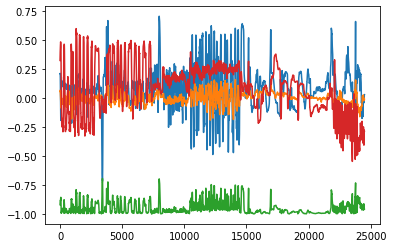

In [169]:
df = pd.DataFrame(continious_dataset)

df.columns = ['qw','qx','qy','qz']
plot = df['qw'].plot()
plot = df['qx'].plot()
plot = df['qy'].plot()
plot = df['qz'].plot()

In [110]:
continious_dataset

[array([ 0.2102486,  0.056532 , -0.9205167,  0.3244203]),
 array([ 0.2101077 ,  0.05895908, -0.9162277 ,  0.336014  ]),
 array([ 0.2101077 ,  0.05895908, -0.9162277 ,  0.336014  ]),
 array([ 0.209517  ,  0.06166424, -0.9122825 ,  0.3464689 ]),
 array([ 0.2084652 ,  0.06386879, -0.9088689 ,  0.3555564 ]),
 array([ 0.2080546 ,  0.06528137, -0.9053354 ,  0.3644441 ]),
 array([-0.2080546 , -0.06528137,  0.9053354 , -0.3644441 ]),
 array([-0.2084876 , -0.06609417,  0.9021229 , -0.3719392 ]),
 array([-0.2097408 , -0.06657591,  0.8992379 , -0.3780844 ]),
 array([-0.2109834 , -0.06640861,  0.8970531 , -0.3825857 ]),
 array([ 0.2109834 ,  0.06640861, -0.8970531 ,  0.3825857 ]),
 array([ 0.2113356 ,  0.06590429, -0.8954843 ,  0.3861371 ]),
 array([ 0.2103041,  0.0659661, -0.8940603,  0.3899705]),
 array([-0.2103041, -0.0659661,  0.8940603, -0.3899705]),
 array([-0.2083911, -0.0667979,  0.8925434, -0.3943065]),
 array([-0.2060306 , -0.06639705,  0.8913026 , -0.3983998 ]),
 array([-0.2023692 , -0.

C:/Users/weikert1/Documents/Thesis/Project_V06_26072021/Data/01_Dataset\1_special_train.csv


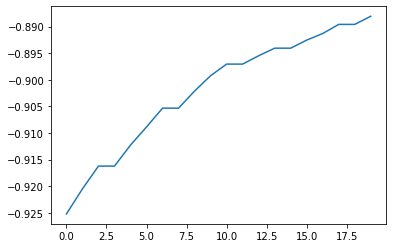

In [141]:

Path_dataset01_test = cfg['Path_dataset01']

for csv in get_csv_files(Path_dataset01_test, "1_special_train"):
        print(csv)
        trace_id = os.path.splitext(os.path.basename(csv))[0]
        csv_df = load_df(csv)
        plot = csv_df['qy'][0:20].plot()
        
        q = csv_df[0:20] 

        in_seq1 = q[['qw']].to_numpy()
        in_seq2 = q[['qx']].to_numpy()
        in_seq3 = q[['qy']].to_numpy()
        in_seq4 = q[['qz']].to_numpy()

        dataset = hstack((in_seq1, in_seq2, in_seq3, in_seq4))


In [147]:
q

,TimeStamp,LeftEye X,LeftEye Y,RightEye X,RightEye Y,Eye X,Eye Y,x,y,z,qx,qy,qz,qw,pitch,yaw,roll
0,2019-07-24 16:14:23.673,0.557369,0.315034,0.532705,0.324764,0.545037,0.319899,0.065756,1.517832,-0.124638,0.055253,-0.925217,0.311678,0.209230,36.85995,206.1579,2.018588
1,2019-07-24 16:14:23.689,0.532282,0.326348,0.522992,0.340885,0.527637,0.333617,0.061242,1.512255,-0.126697,0.056532,-0.920517,0.324420,0.210249,38.39214,206.5551,2.364831
2,2019-07-24 16:14:23.705,0.532282,0.326348,0.522992,0.340885,0.527637,0.333617,0.056540,1.506796,-0.128884,0.058959,-0.916228,0.336014,0.210108,39.82957,206.7280,2.474663
3,2019-07-24 16:14:23.722,0.525359,0.331756,0.519742,0.345977,0.522550,0.338867,0.056540,1.506796,-0.128884,0.058959,-0.916228,0.336014,0.210108,39.82957,206.7280,2.474663
4,2019-07-24 16:14:23.739,0.522866,0.335295,0.518064,0.349747,0.520465,0.342521,0.052011,1.501456,-0.131235,0.061664,-0.912282,0.346469,0.209517,41.14710,206.8023,2.486710
5,2019-07-24 16:14:23.756,0.523064,0.337313,0.518490,0.351114,0.520777,0.344213,0.047540,1.496397,-0.133891,0.063869,-0.908869,0.355556,0.208465,42.29417,206.8003,2.490721
6,2019-07-24 16:14:23.772,0.523421,0.345746,0.521719,0.359690,0.522570,0.352718,0.042386,1.491652,-0.136862,0.065281,-0.905335,0.364444,0.208055,43.39723,206.9348,2.638234
7,2019-07-24 16:14:23.789,0.523421,0.345746,0.521719,0.359690,0.522570,0.352718,0.042386,1.491652,-0.136862,0.065281,-0.905335,0.364444,0.208055,43.39723,206.9348,2.638234
8,2019-07-24 16:14:23.804,0.526497,0.354032,0.524293,0.363916,0.525395,0.358974,0.036731,1.487156,-0.140308,0.066094,-0.902123,0.371939,0.208488,44.31715,207.1956,2.871203
9,2019-07-24 16:14:23.822,0.526497,0.354032,0.524293,0.363916,0.525395,0.358974,0.031039,1.482465,-0.143962,0.066576,-0.899238,0.378084,0.209741,45.06455,207.5671,3.154257


In [142]:
q = np.array([Quaternion(q) for q in dataset]) 
ang_dist_1 = [Quaternion.distance(q1,q2) for q1,q2 in zip(q[:-1], q[1:])]
ang_dist_1


[0.013679656948756159,
 0.012598495099680314,
 2.2204460492503128e-16,
 0.011512507211513652,
 0.010010119215696715,
 0.009676855702849214,
 1.1102230246251565e-16,
 0.008206411425234393,
 0.006920222426936479,
 0.005158212008019221,
 0.0,
 0.003930900228893104,
 0.004217886721721821,
 0.0,
 0.005045135482812278,
 0.0049017729474163,
 0.007040921767732781,
 1.1102230246251565e-16,
 0.007093087200349964]

In [143]:
q = np.array([Quaternion(q) for q in dataset]) 
ang_dist = [Quaternion.distance(q1,-q2) for q1,q2 in zip(q[:-1], q[1:])]
ang_dist

[3.1279129966414687,
 3.128994158490362,
 3.1415926535897936,
 3.1300801463784236,
 3.131582534374182,
 3.131915797887007,
 1.1102230246251565e-16,
 3.1333862421645953,
 3.1346724311632936,
 3.1364344415817764,
 0.0,
 3.137661753361093,
 3.1373747668681427,
 0.0,
 3.136547518106981,
 3.136690880643911,
 3.1345517318223033,
 3.141592653589793,
 3.134499566389444]

In [144]:
res = np.array(ang_dist_1) - np.array(ang_dist)
res

array([-3.11423334, -3.11639566, -3.14159265, -3.11856764, -3.12157242,
       -3.12223894,  0.        , -3.12517983, -3.12775221, -3.13127623,
        0.        , -3.13373085, -3.13315688,  0.        , -3.13150238,
       -3.13178911, -3.12751081, -3.14159265, -3.12740648])

In [42]:
quat = np.array([Quaternion(q) for q in dataset]) 
continious_dataset = []
state_changes = []


def representation_1(q):
    quaternion = []
    quaternion.append([q[0],q[1],q[2],q[3]])
    return np.array(quaternion)
    
def representation_2(q):
    quaternion = []
    quaternion.append([-q[0],-q[1],-q[2],-q[3]])
    return np.array(quaternion)

for q1,q2 in zip(quat[:-1],quat[1:]):
    if Quaternion.distance(q1,q2) < Quaternion.distance(q1,-q2):
        state_changes.append(0)
    else:
        state_changes.append(1)

cum_sum = np.cumsum(np.array(state_changes))

    
for idx,state in enumerate(cum_sum):
    if state%2 == 0:
        continious_dataset.append(representation_1(quat[idx]))
    else:
        continious_dataset.append(representation_2(quat[idx]))

In [41]:
continious_dataset

[array([[ 0.2619402 ,  0.01412961, -0.9481148 ,  0.1796277 ]]),
 array([[ 0.2611263 ,  0.01395291, -0.9481726 ,  0.1805193 ]]),
 array([[ 0.2603256,  0.0135597, -0.9481325,  0.1819109]]),
 array([[ 0.2595809 ,  0.01352669, -0.9476516 ,  0.1854485 ]]),
 array([[ 0.2595325 ,  0.01354926, -0.9473895 ,  0.186849  ]]),
 array([[ 0.2590392,  0.0126824, -0.9471136,  0.1889808]]),
 array([[ 0.2567907,  0.0097557, -0.9471914,  0.1918119]]),
 array([[ 0.2550227 ,  0.00811377, -0.9472622 ,  0.1938864 ]]),
 array([[ 0.2524134 ,  0.00648238, -0.9473904 ,  0.1967151 ]]),
 array([[ 0.2454117 ,  0.00452978, -0.9481776 ,  0.2017715 ]]),
 array([[ 0.2409113 ,  0.00442663, -0.9490312 ,  0.2031798 ]]),
 array([[ 0.229197  ,  0.00526178, -0.9518311 ,  0.2036139 ]]),
 array([[ 0.2213826 ,  0.00547822, -0.9538917 ,  0.2026088 ]]),
 array([[ 0.2028665,  0.0049193, -0.9582758,  0.2013168]]),
 array([[ 0.1920362 ,  0.00442494, -0.9604642 ,  0.2015217 ]]),
 array([[ 0.1687362 ,  0.00329137, -0.964489  ,  0.20317

In [257]:
Path_dataset01_test = cfg['Path_dataset01']

for csv in get_csv_files(Path_dataset01_test, "1_full"):
        print(csv)
        trace_id = os.path.splitext(os.path.basename(csv))[0]
        csv_df = load_df(csv)
        #plot = csv_df['qy'][9300:9400].plot()
        
        q = csv_df
        
        


        in_seq1 = q[['qw']].to_numpy()
        in_seq2 = q[['qx']].to_numpy()
        in_seq3 = q[['qy']].to_numpy()
        in_seq4 = q[['qz']].to_numpy()
        
        in_seq5 = q[['x']].to_numpy()
        in_seq6 = q[['y']].to_numpy()
        in_seq7 = q[['z']].to_numpy()
        
        dataset_quat = hstack((in_seq1, in_seq2, in_seq3, in_seq4))
        
        dataset_pos = hstack((in_seq5, in_seq6, in_seq7))
        print(len(dataset_pos))


C:/Users/weikert1/Documents/Thesis/Project_V06_26072021/Data/01_Dataset\1_full.csv
35000


In [258]:
quat = np.array([Quaternion(q) for q in dataset_quat]) 
continious_dataset = []
state_changes = []
dist = []

def representation_1(q):
    quaternion = []
    quaternion.append([q[0],q[1],q[2],q[3]])
    return np.array(quaternion).reshape(4,)
    
def representation_2(q):
    quaternion = []
    quaternion.append([-q[0],-q[1],-q[2],-q[3]])
    return np.array(quaternion).reshape(4,)

for q1,q2 in zip(quat[:-1],quat[1:]):
    if Quaternion.distance(q1,q2) <= Quaternion.distance(q1,-q2):
        state_changes.append(0)
        dist.append(Quaternion.distance(q1,q2))
    else:
        state_changes.append(1)
        dist.append(Quaternion.distance(q1,-q2))

cum_sum = np.cumsum(np.array(state_changes))

    
for idx,state in enumerate(cum_sum):
    
    if state%2 == 0:
        continious_dataset.append(representation_1(quat[idx+1]))
    else:
        continious_dataset.append(representation_2(quat[idx+1]))

In [259]:
data_df_quat = pd.DataFrame(np.array(continious_dataset), columns= cfg['quat_coords'])
print(len(data_df_quat))

dataset_pos_adj = dataset_pos[1:]
data_df_pos = pd.DataFrame(np.array(dataset_pos_adj), columns= cfg['pos_coords'])
print(len(data_df_pos))


df_rot_result = pd.concat([data_df_pos, data_df_quat], axis=1)

df_rot_result.to_csv(os.path.join(Path_dataset01_test, '1_full_continious.csv'), index=False)


34999
34999


In [62]:
Path_dataset01_test = cfg['Path_dataset01']

for csv in get_csv_files(Path_dataset01_test, "1_special_test_con"):
        print(csv)
        trace_id = os.path.splitext(os.path.basename(csv))[0]
        csv_df = load_df(csv)
        #plot = csv_df['qy'][9300:9400].plot()
        
        q = csv_df

        in_seq1 = q[['qw']].to_numpy()
        in_seq2 = q[['qx']].to_numpy()
        in_seq3 = q[['qy']].to_numpy()
        in_seq4 = q[['qz']].to_numpy()

        quat = hstack((in_seq1, in_seq2, in_seq3, in_seq4))
            
for csv in get_csv_files(Path_dataset01_test, "1_special_test_or"):
        print(csv)
        trace_id = os.path.splitext(os.path.basename(csv))[0]
        csv_df = load_df(csv)
        g = csv_df
        
        in_seq5 = g[['Eye X']].to_numpy()
        in_seq6 = g[['Eye Y']].to_numpy()
        
        gaze = hstack((in_seq5, in_seq6))
        gaze = gaze[:-1]



C:/Users/Thomas Weikert/Documents/Thesis/Project_V07_24092021/Data/01_Dataset\1_special_test_continious.csv
C:/Users/Thomas Weikert/Documents/Thesis/Project_V07_24092021/Data/01_Dataset\1_special_test_original.csv


In [63]:
dt_gaze = np.concatenate((quat, gaze), axis=1)
df_gaze = pd.DataFrame(dt_gaze, columns = ['qw','qx','qy','qz','Eye X', 'Eye Y'])
df_gaze.to_csv(os.path.join(Path_dataset01_test, '1_gaze_test_continious.csv'), index=False)

array([[ 0.2102486 ,  0.056532  , -0.9205167 ,  0.3244203 ,  0.5450371 ,
         0.3198987 ],
       [ 0.2101077 ,  0.05895908, -0.9162277 ,  0.336014  ,  0.5276369 ,
         0.3336166 ],
       [ 0.2101077 ,  0.05895908, -0.9162277 ,  0.336014  ,  0.5276369 ,
         0.3336166 ],
       ...,
       [ 0.0294607 , -0.01195417, -0.9565706 , -0.2897619 ,  0.5304047 ,
         0.2681429 ],
       [ 0.02999678, -0.0115245 , -0.9570589 , -0.2881069 ,  0.5304047 ,
         0.2681429 ],
       [ 0.02999678, -0.0115245 , -0.9570589 , -0.2881069 ,  0.5304047 ,
         0.2681429 ]])